<a href="https://colab.research.google.com/github/ontenkutsenko/DL_Skin_Disease_Classification/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
!pip install tensorflow_addons
!pip install opencv-contrib-python

import tensorflow_addons as tfa

import pickle

import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil

from tensorflow.keras.applications import ResNet50, VGG16, VGG19, imagenet_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
import imutils

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import time

from sklearn.metrics import f1_score
import seaborn as sns
from PIL import Image

ModuleNotFoundError: No module named 'pyimagesearch'

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing the data

In [32]:
#download weights of the best model
!gdown 16FJYqv05B9l2xJUsWw-glSmIkbjfMKcJ

#download images
!gdown 1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc

time.sleep(2)

!unzip -q "/content/Images for project.zip" -d /content/
!rm '/content/Images for project.zip'

Downloading...
From: https://drive.google.com/uc?id=16FJYqv05B9l2xJUsWw-glSmIkbjfMKcJ
To: /content/weights_history_input_128.h5
100% 61.5M/61.5M [00:00<00:00, 276MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc
From (redirected): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc&confirm=t&uuid=ee2fdb1c-0800-4b41-8d8e-e4610ce63f4e
To: /content/Images for project.zip
100% 1.42G/1.42G [00:12<00:00, 118MB/s]
replace /content/Images for project/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#### Sorting the images into separate train-val-test folders

In [33]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

Our dataset contains information of skin color, which may be really important in case of Computer Vision task. We don't want our model to be biased, so we will stratify data in train, validation and test not only by label, but by every skin color, using fitzpatrick_scale. It will help to achieve better generalization and make validation stage more reliable

In [34]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [35]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [36]:
# Proportions do not exactly match what we defined because of rare skin color and class combinations that

proportion = {
    'train': 0.70,
    'val': 0.10,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

split
train    0.687712
test     0.188800
val      0.123488
Name: count, dtype: float64

In [37]:
shutil.rmtree('/content/dataset', ignore_errors=True)

source_folder = '/content/Images for project'
destination_folder = '/content/dataset'


for i in range(len(df)):
  try:
    source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
    destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], f"{df['url'][i].split('/')[-1]}.jpg")
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)

    shutil.move(source_file, destination_file)
  except:
    print(source_file, ' doesn\'t exist')

/content/Images for project/img?imageId=4030  doesn't exist
/content/Images for project/img?imageId=8364  doesn't exist
/content/Images for project/img?imageId=2767  doesn't exist
/content/Images for project/img?imageId=4031  doesn't exist
/content/Images for project/img?imageId=5399  doesn't exist
/content/Images for project/img?imageId=2766  doesn't exist
/content/Images for project/img?imageId=6724  doesn't exist
/content/Images for project/img?imageId=4505  doesn't exist
/content/Images for project/img?imageId=8362  doesn't exist
/content/Images for project/img?imageId=8363  doesn't exist


#### Define model and test data generator

In [39]:
# Data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Model
batch_size = 64

input_size = (128,128)

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        batch_size=batch_size,
        shuffle = False,
        class_mode='categorical',
        target_size=input_size)

tf.compat.v1.reset_default_graph()

input_size = (128,128)
# Instance of our pretrained model we will use
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size + (3,))
# Make only the top layers of the base model trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])

print(model.layers[-1].weights[0])

sgd_optimizer = SGD(lr=0.001, momentum=0.9)

weighted_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'weighted', name = 'weighted_f1')
macro_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'macro', name = 'macro_f1')

model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score, macro_f1_score])

model.load_weights('/content/weights_history_input_128.h5')

print(model.layers[-1].weights[0])

# for layer in model.layers[:]:
#     layer.trainable = False

Found 3118 images belonging to 114 classes.


<tf.Variable 'dense_1/kernel:0' shape=(1024, 114) dtype=float32, numpy=
array([[ 0.0507364 ,  0.02541994, -0.02706451, ..., -0.04509295,
         0.00081678, -0.04396291],
       [-0.00570474,  0.06528485, -0.06012111, ...,  0.01225036,
        -0.00400262, -0.02399752],
       [-0.05715655,  0.01036073, -0.02717716, ...,  0.04621417,
         0.0668328 , -0.06508756],
       ...,
       [-0.00356907,  0.0010908 ,  0.04159828, ...,  0.01058371,
        -0.03746905, -0.06826256],
       [ 0.03740618, -0.02787295,  0.02350763, ..., -0.01139277,
        -0.04691743, -0.03771756],
       [-0.01532658, -0.05875482, -0.04972303, ...,  0.05249676,
        -0.05382649, -0.02590228]], dtype=float32)>
<tf.Variable 'dense_1/kernel:0' shape=(1024, 114) dtype=float32, numpy=
array([[ 0.04465518, -0.06790195,  0.04509483, ..., -0.05579664,
        -0.02073681,  0.02370812],
       [ 0.07220843, -0.02652145, -0.02055929, ..., -0.02284409,
         0.01634226, -0.01124442],
       [-0.04432542,  0.067

#### Save predictions and true values

In [40]:
predictions = model.predict(test_generator, verbose = 'auto')

predicted_classes = predictions.argmax(axis=1)

class_labels = list(test_generator.class_indices.keys())

for prediction in predicted_classes:
    print(class_labels[prediction])

49/49 [==============================] - 13s 268ms/step
papilomatosis confluentes and reticulate
drug eruption
acne vulgaris
fixed eruptions
pityriasis rosea
papilomatosis confluentes and reticulate
cheilitis
pityriasis rosea
ichthyosis vulgaris
papilomatosis confluentes and reticulate
lichen planus
papilomatosis confluentes and reticulate
scabies
halo nevus
syringoma
acanthosis nigricans
acanthosis nigricans
photodermatoses
congenital nevus
neurofibromatosis
papilomatosis confluentes and reticulate
acne
allergic contact dermatitis
folliculitis
acne vulgaris
psoriasis
acne vulgaris
photodermatoses
neurofibromatosis
folliculitis
acne vulgaris
lupus erythematosus
sarcoidosis
sarcoidosis
acne vulgaris
acne vulgaris
acne vulgaris
folliculitis
pityriasis rosea
folliculitis
acne
folliculitis
psoriasis
folliculitis
seborrheic keratosis
acne vulgaris
acne vulgaris
lupus erythematosus
lupus erythematosus
porokeratosis actinic
scabies
pityriasis rubra pilaris
pilar cyst
folliculitis
acne vulgari

In [41]:
predictions_copy = predictions.copy()

In [42]:
#create dataframe for analysis

url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df1 = pd.read_csv(url).dropna(subset = ['url'])
df1['key'] = df1['label'] + '/' + df1['url'].apply(lambda x: x.split('/')[-1] + '.jpg')
df2 = pd.DataFrame({
    'key': test_generator.filenames,
    'true_class': test_generator.classes,
    'pred_class': predictions.argmax(axis=1),
    'pred_prob' : predictions.tolist()
})
reverse_dict = {value: key for key, value in test_generator.class_indices.items()}
df2['pred_label'] = df2['pred_class'].apply(lambda x: reverse_dict[x])

test_info = pd.merge(df1, df2, left_on='key', right_on='key')
test_info.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum,key,true_class,pred_class,pred_prob,pred_label
0,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...,photodermatoses/photosensitivity18.jpg.jpg,75,75,"[0.009285233914852142, 0.0011654254049062729, ...",photodermatoses
1,e702b1a7dc40aa1d8e85ccdb019c4ab2,1,1,neutrophilic dermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicssweet...,neutrophilic dermatoses/sweet-syndrome50.jpg.jpg,68,75,"[0.00036442637792788446, 0.020064257085323334,...",photodermatoses
2,8438db40abd1eccfbc7ee4b469f1b6f1,4,3,necrobiosis lipoidica,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicnnecro...,necrobiosis lipoidica/necrobiois-lipoidica-dia...,63,75,"[0.0008953498327173293, 0.0006957374862395227,...",photodermatoses
3,b09233673fc585369e723ec841ed0acb,5,3,actinic keratosis,malignant epidermal,malignant,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicaactin...,actinic keratosis/actinic_keratoses83.jpg.jpg,5,86,"[0.0002434756315778941, 0.013781887479126453, ...",psoriasis
4,fb9640a13e0c11610684fe8c0f473cf2,2,2,syringoma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicssyrin...,syringoma/syringoma33.jpg.jpg,104,44,"[0.004604179412126541, 0.002957293763756752, 0...",keratosis pilaris


#### Define metrics and calculate performance from different perspectives

In [43]:
def top_n_accuracy(y_val, val_predictions, n):
  diff = np.min(np.abs(y_val.reshape(-1, 1) - np.argsort(val_predictions, axis=1)[:,-n:]), axis = 1)
  return np.count_nonzero(diff == 0)/len(diff)

In [44]:
print(top_n_accuracy(test_info['true_class'].to_numpy(), np.array(test_info['pred_prob'].to_list()), 1))
print(top_n_accuracy(test_info['true_class'].to_numpy(), np.array(test_info['pred_prob'].to_list()), 3))
print(top_n_accuracy(test_info['true_class'].to_numpy(), np.array(test_info['pred_prob'].to_list()), 5))
print(f1_score(test_info['true_class'].to_numpy(), test_info['pred_class'].to_numpy(), average='weighted'))
print(f1_score(test_info['true_class'].to_numpy(), test_info['pred_class'].to_numpy(), average='macro'))

0.28960872354073125
0.45349583066067994
0.5461834509300834
0.26915725148301156
0.23895825840363596


In [45]:
  # weighted_f1_cat = f1_score(cat_slice_df['true_class'].to_numpy(),
  #                            cat_slice_df['pred_class'].to_numpy())
  # macro_f1_cat = f1_score(cat_slice_df['true_class'].to_numpy(),
  #                         cat_slice_df['pred_class'].to_numpy(),
  #                         average='macro')

100%|██████████| 114/114 [00:00<00:00, 602.89it/s]


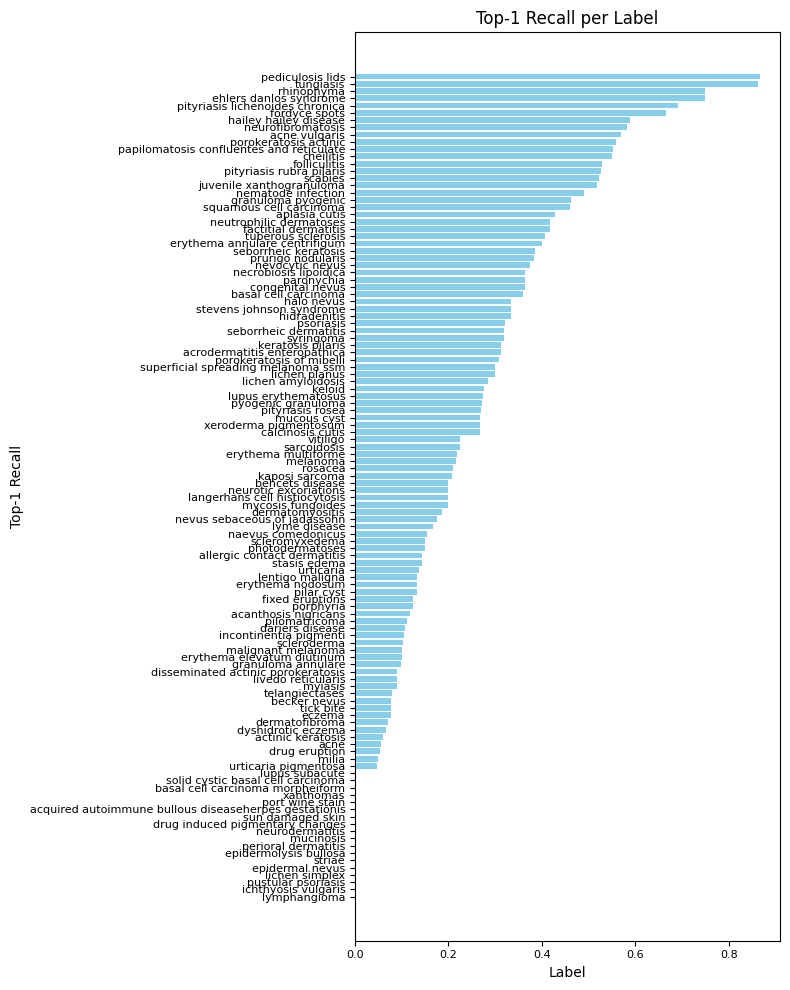

100%|██████████| 108/108 [00:00<00:00, 563.93it/s]


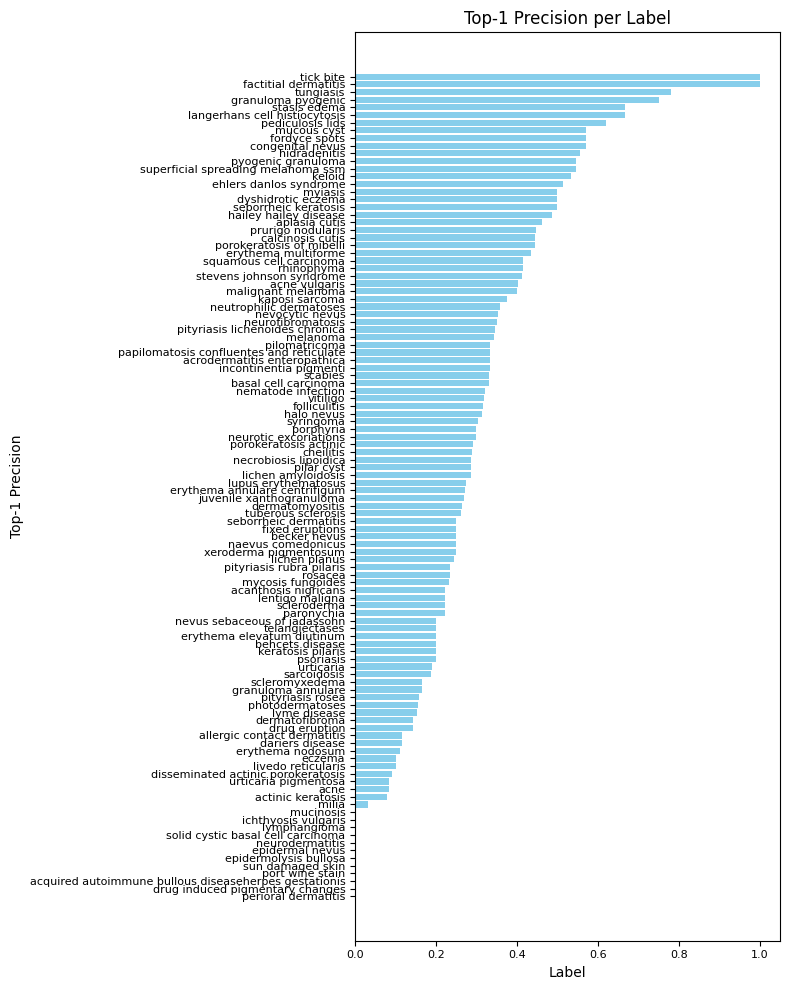

In [46]:
# Its not accuracy, but recall


category = 'label'

cat_calc = []
for i in tqdm(list(set(test_info[category]))):
  cat_slice_df = test_info[test_info[category] == i]
  top_1 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 1)
  top_3 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 3)
  top_5 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 5)

  cat_calc.append([i, len(cat_slice_df), top_1, top_3, top_5])
cat_performance_df = pd.DataFrame(cat_calc, columns= ['label', 'count', 'top_1_recall', 'top_3_recall', 'top_5_recall'])

sorted_df = cat_performance_df.sort_values(by='top_1_recall', ascending=True)


plt.figure(figsize=(8, 10))
plt.barh(sorted_df['label'], sorted_df['top_1_recall'], color='skyblue')
plt.title('Top-1 Recall per Label')
plt.xlabel('Label')
plt.ylabel('Top-1 Recall')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


# Its not accuracy, but precision

cat_calc = []
category = 'pred_label'
for i in tqdm(list(set(test_info[category]))):
  cat_slice_df = test_info[test_info[category] == i]
  top_1 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 1)
  top_3 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 3)
  top_5 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 5)

  cat_calc.append([i, len(cat_slice_df), top_1, top_3, top_5])
cat_performance_df_1 = pd.DataFrame(cat_calc, columns= ['label', 'count', 'top_1_precision', 'top_3_precision', 'top_5_precision'])

sorted_df = cat_performance_df_1.sort_values(by='top_1_precision', ascending=True)


plt.figure(figsize=(8, 10))
plt.barh(sorted_df['label'], sorted_df['top_1_precision'], color='skyblue')
# plt.plot(sorted_df['count'], sorted_df['label'], color='skyblue')
plt.title('Top-1 Precision per Label')
plt.xlabel('Label')
plt.ylabel('Top-1 Precision')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [47]:
# Recall on 30 biggest true classes

cat_performance_df.sort_values(by='count', ascending=False).head(30).drop('label', axis = 1).mean()

count           57.366667
top_1_recall     0.327999
top_3_recall     0.496695
top_5_recall     0.594777
dtype: float64

In [48]:
# Precision on 30 biggest predicted classes

cat_performance_df_1.sort_values(by='count', ascending=False).head(30).drop('label', axis = 1).mean()

count              71.566667
top_1_precision     0.312138
top_3_precision     0.474990
top_5_precision     0.560648
dtype: float64

In [49]:
# Recall on 30 smallest classes

cat_performance_df.sort_values(by='count', ascending=False).tail(30).drop('label', axis = 1).mean()

count           10.966667
top_1_recall     0.139387
top_3_recall     0.262826
top_5_recall     0.312429
dtype: float64

In [50]:
# Precision on 30 smallest predicted classes

cat_performance_df_1.sort_values(by='count', ascending=False).tail(30).drop('label', axis = 1).mean()

count              4.566667
top_1_precision    0.321455
top_3_precision    0.462963
top_5_precision    0.576508
dtype: float64

If we look on count number - average count of top predicted classes is way bigger than average count of top true classes. And the opposite for smallest. It means that distribution of predicted classes is way more extreme - model likes to predict some classes that it have seen more or know batter. Let's compare what are the most/least popular true classes and most/least popular predicted classes (!! might change when we put different model)

In [51]:
pop_pred = set(cat_performance_df_1.sort_values(by='count', ascending=False).head(30)['label'])
pop_true = set(cat_performance_df.sort_values(by='count', ascending=False).head(30)['label'])

len(pop_pred.intersection(pop_true))

22

In [52]:
unpop_pred = set(cat_performance_df_1.sort_values(by='count', ascending=False).tail(30)['label'])
unpop_true = set(cat_performance_df.sort_values(by='count', ascending=False).tail(30)['label'])

len(unpop_pred.intersection(unpop_true))

18

In [159]:
cat_performance_df.set_index('label', inplace=True)
cat_performance_df_1.set_index('label', inplace=True)
ratio_predicted = pd.DataFrame((cat_performance_df_1['count']/cat_performance_df['count']).fillna(0).sort_values(ascending=False))
ratio_predicted_df = pd.merge(ratio_predicted, cat_performance_df['count'], left_index=True, right_index=True, how='inner')
ratio_predicted_df.rename(columns={'count_x': 'ratio_predicted', 'count_y': 'count_elements'}, inplace=True)
ratio_predicted_df.corr()

,count
label,
pityriasis rubra pilaris,2.236364
pityriasis lichenoides chronica,2.000000
juvenile xanthogranuloma,1.925926
porokeratosis actinic,1.911765
cheilitis,1.900000
...,...
pustular psoriasis,0.000000
lupus subacute,0.000000
lichen simplex,0.000000


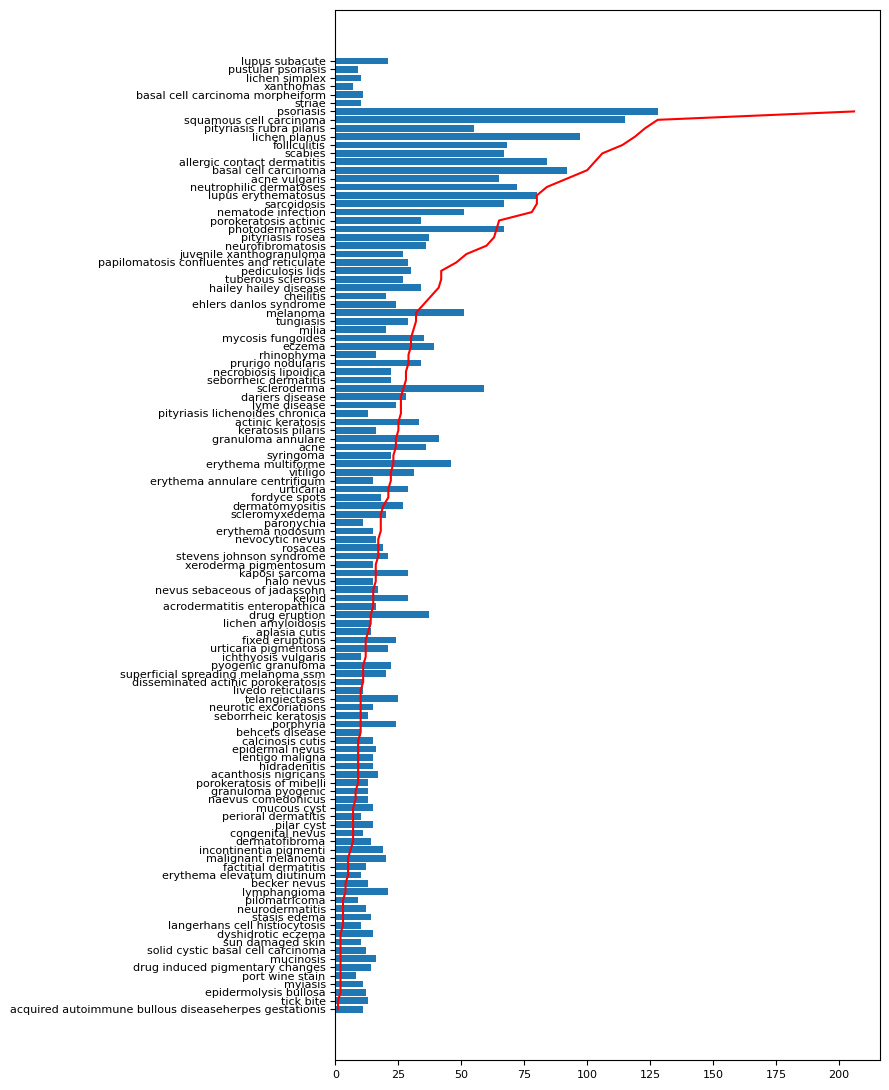

In [66]:
plt.figure(figsize=(9, 11))

plt.plot(cat_performance_df_1.sort_values(by = 'count')['count'],
         cat_performance_df_1.sort_values(by = 'count')['label'],
         color = 'red')
plt.barh(cat_performance_df['label'], cat_performance_df['count'])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

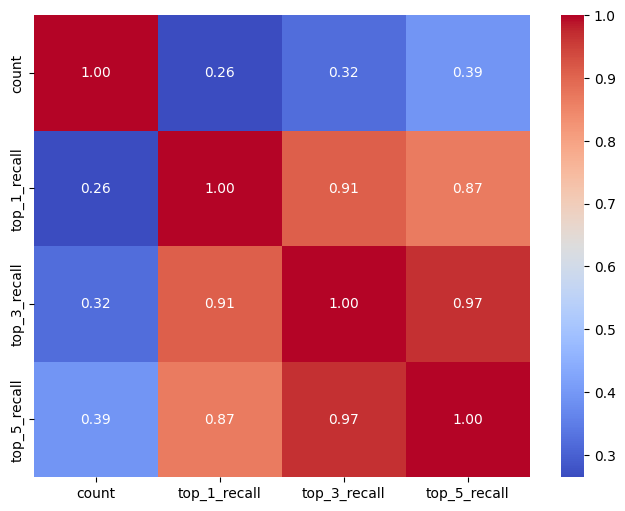

In [54]:
correlation_matrix = cat_performance_df.select_dtypes(include='number').corr()
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

#### picture analysis

In [55]:
def display_images(image_paths):
    images_in_row = 4
    num_images = len(image_paths)
    num_rows = num_images // images_in_row + (num_images % images_in_row > 0)
    fig, axes = plt.subplots(num_rows, images_in_row, figsize=(16, images_in_row * num_rows))

    for i, path in enumerate(image_paths):
        row = i // images_in_row
        col = i % images_in_row
        ax = axes[row, col] if num_rows > 1 else axes[col]
        img = Image.open(path)
        ax.imshow(img)
        obs = test_info[test_info['key'] == path.split('test/')[1]]
        ax.set_title(f"Correct class: {obs['label'].values[0]}\nPredicted class: {obs['pred_label'].values[0]}", fontsize=8)


    # Hide axes
    for i in range( num_rows * images_in_row):
        row = i // images_in_row
        col = i % images_in_row
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis('off')



    plt.tight_layout()
    plt.show()

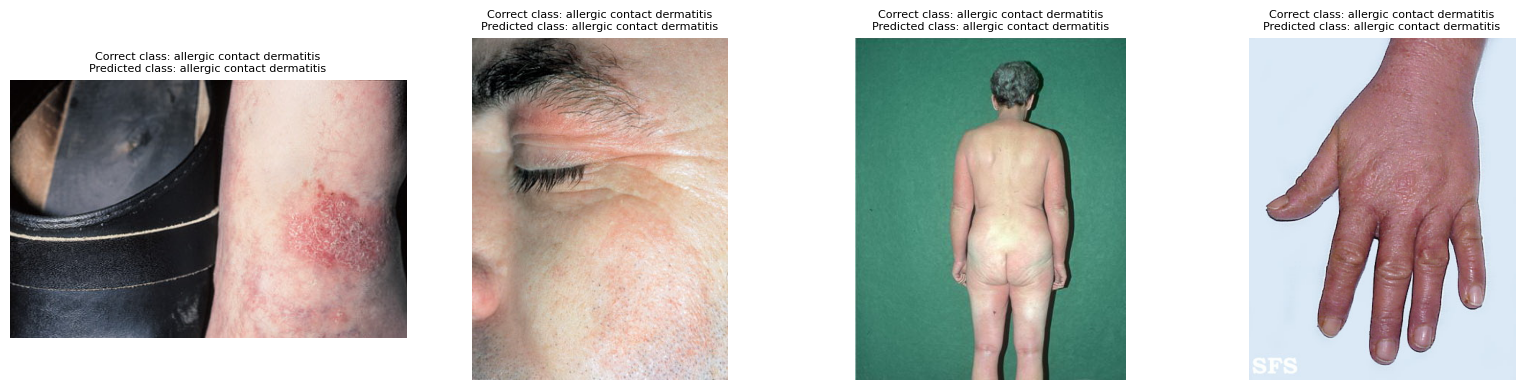

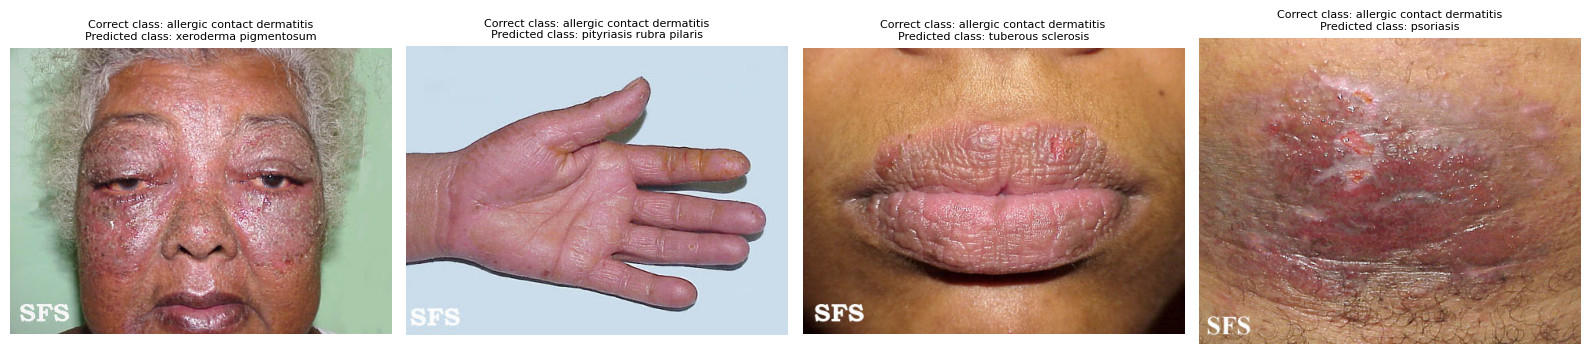

In [56]:
label = 'allergic contact dermatitis'

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] == test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).tail(4).to_list()
display_images(image_paths)

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] != test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).tail(4).to_list()

display_images(image_paths)

What else to do
- grad cam
- check cases when big share one class was transferred to another class
- different perspectives (benign/mailgnant, skin color)

#### GradCAM

In [56]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

  def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])

    # record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap


  def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)


# The model was already loaded previously (model). Lets handle the image
path_to_image = ''
orig = cv2.imread(path_to_imageh)
resized = cv2.resize(orig, (224, 224))

image = load_img(path_to_image, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)


# use the network to make predictions on the input image and find
# the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])
# decode the ImageNet predictions to obtain the human-readable label
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.8, (255, 255, 255), 2)

# display the original image and resulting heatmap and output image to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2.imshow("Output", output)
cv2.waitKey(0)